In [1]:
import numpy as np
import os, datetime
from glob import glob
import re

import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import torch.distributions as tfd
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from scipy.stats import norm
import matplotlib.pyplot as plt
import h5py, corner
from scipy.interpolate import interp1d

from matplotlib import rcParams
rcParams.update({'font.size': 12})

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrast

In [2]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm

%matplotlib inline


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/tutorial9")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [3]:
from pathlib import Path
import os

In [4]:
path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'

In [5]:
import sys
sys.path.insert(1, '/home/dbreitman')
from dani_utils.plotting import imshow_error_2D, plot_hist
from dani_utils.test_funcs import Normalize, diag_cov

In [23]:
f = np.load(path + 'sept_db_90_thetas_wlog.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
std_seeds = f['PS_2D_stds']
std_means = f['PS_2D_std_means']
std_poisson = f['poisson_stds']
ps_data = np.append(seeds[...,np.newaxis], means[...,np.newaxis], axis = -1)
print(ps_data.shape)
N_samples = ps_data.shape[0]
shape1 = (ps_data.shape[0] * ps_data.shape[1], ps_data.shape[2], ps_data.shape[3], 2)
ps_data = ps_data.reshape(shape1)
std_means = std_means.reshape(shape1[:-1])
std_poisson = std_poisson.reshape(shape1[:-1])
print(ps_data.shape)
print(std_means.min(), std_means.max())
noisy_norm = Normalize(ps_data[...,0], log = False, axis = 0)

mean_norm = Normalize(ps_data[...,1], log = False, axis = 0)

std_std = np.std(std_means, axis = 0)

f = np.load(path + 'sept_db_10_thetas_wlog.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
std_seeds = f['PS_2D_stds']
std_means = f['PS_2D_std_means']
std_poisson = f['poisson_stds']
ps_data = np.append(seeds[...,np.newaxis], means[...,np.newaxis], axis = -1)
print(ps_data.shape)
N_samples = ps_data.shape[0]
shape1 = (ps_data.shape[0] * ps_data.shape[1], ps_data.shape[2], ps_data.shape[3], 2)
ps_data = ps_data.reshape(shape1)
std_means = std_means.reshape(shape1[:-1])
std_poisson = std_poisson.reshape(shape1[:-1])
print(ps_data.shape)
print(std_means.min(), std_means.max())
noisy, noisy_mean, noisy_std = noisy_norm.get_normed_data(ps_data[...,0])

mean, mean_mean, mean_std = mean_norm.get_normed_data(ps_data[...,1])

std = std_means / std_std

(11784, 16, 16, 16, 2)
(188544, 16, 16, 2)
0.01 6.848579211066684
(2456, 16, 16, 16, 2)
(39296, 16, 16, 2)
0.01 6.627449402398483


In [24]:
batch_size = 128
name = 'Oct16'
model_path = '/home/dbreitman/CV_PS_denoising/Oct_models/AEs/'

In [25]:
print(mean.min(), mean.max())
print(std.min(), std.max())


X_test = noisy
Y_test = np.append(mean[...,np.newaxis], std[...,np.newaxis], axis = -1)

print(X_test.shape)

-3.501439367194377 1.7391020761705605
0.018640647545835175 14.113105001924078
(39296, 16, 16)


In [36]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(),
        )
        
        self.resblock = nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
        )
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.LazyLinear(latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 32
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(),
                                   nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [28]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.LazyLinear(latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [9]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2), #8x8 => 16x16
            #act_fn(),
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...]-self.floorT)[:, np.newaxis,...] +self.floorT), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [10]:
nbatches = X_test.shape[0] // batch_size

In [11]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [18]:
model = Autoencoder(base_channel_size = 64, latent_dim = 128, num_input_channels = 1, 
                    num_output_channels = 2)

In [19]:
model.load_state_dict(torch.load(model_path+'Oct16_KL'))

<All keys matched successfully>

In [27]:
Y_pred = model(torch.Tensor(X_test[:, np.newaxis,...]).to(device)).detach().cpu().numpy()
print(Y_pred.shape)
std_pred = (torch.Tensor(Y_pred[:,1,...])) * std_std
mean_pred = (torch.Tensor(Y_pred[:,0,...]) * mean_std) + mean_mean

(39296, 2, 16, 16)


In [28]:
ffee = abs((std_pred - std_means) / std_means)
med_fe = np.nanmedian(ffee, axis = 0)
print(np.nanmean(med_fe))

2.780603754416743


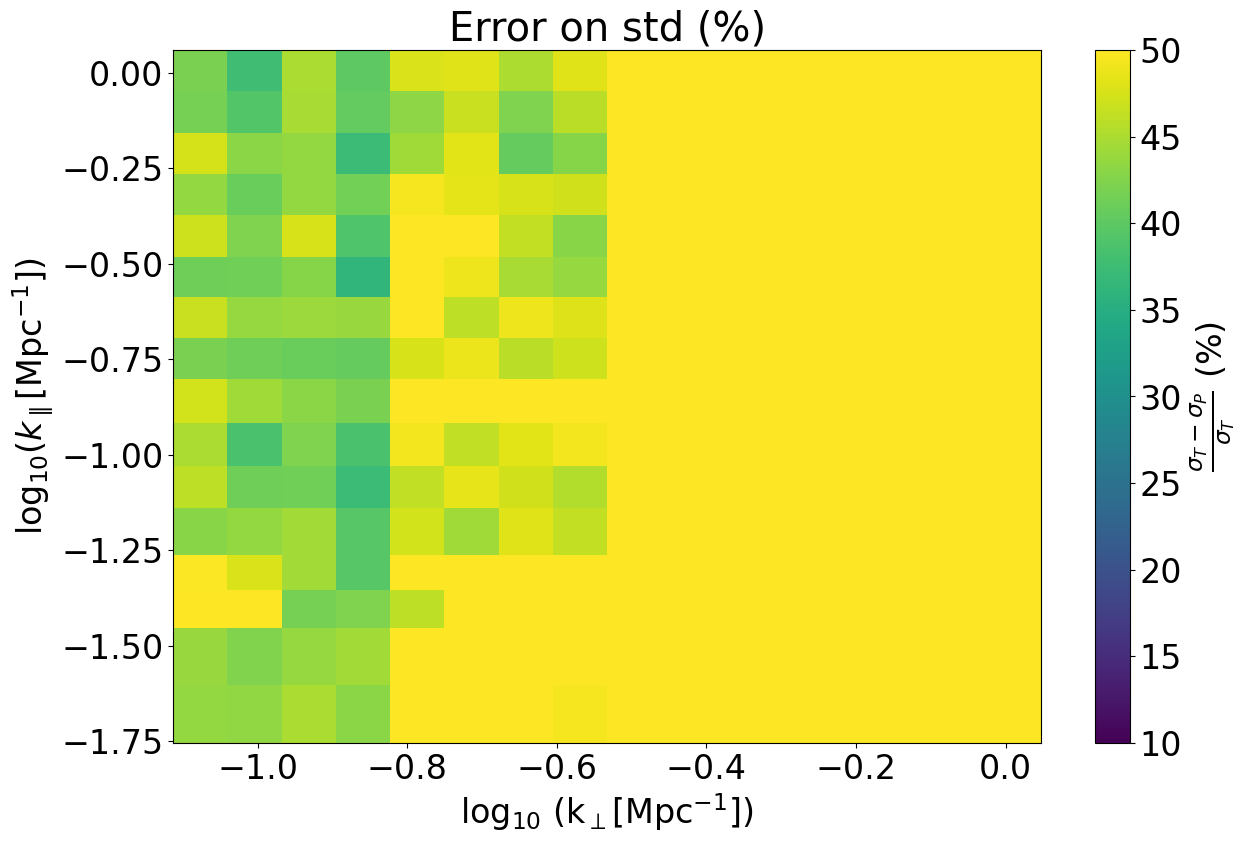

In [44]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 10, vmax = 50., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

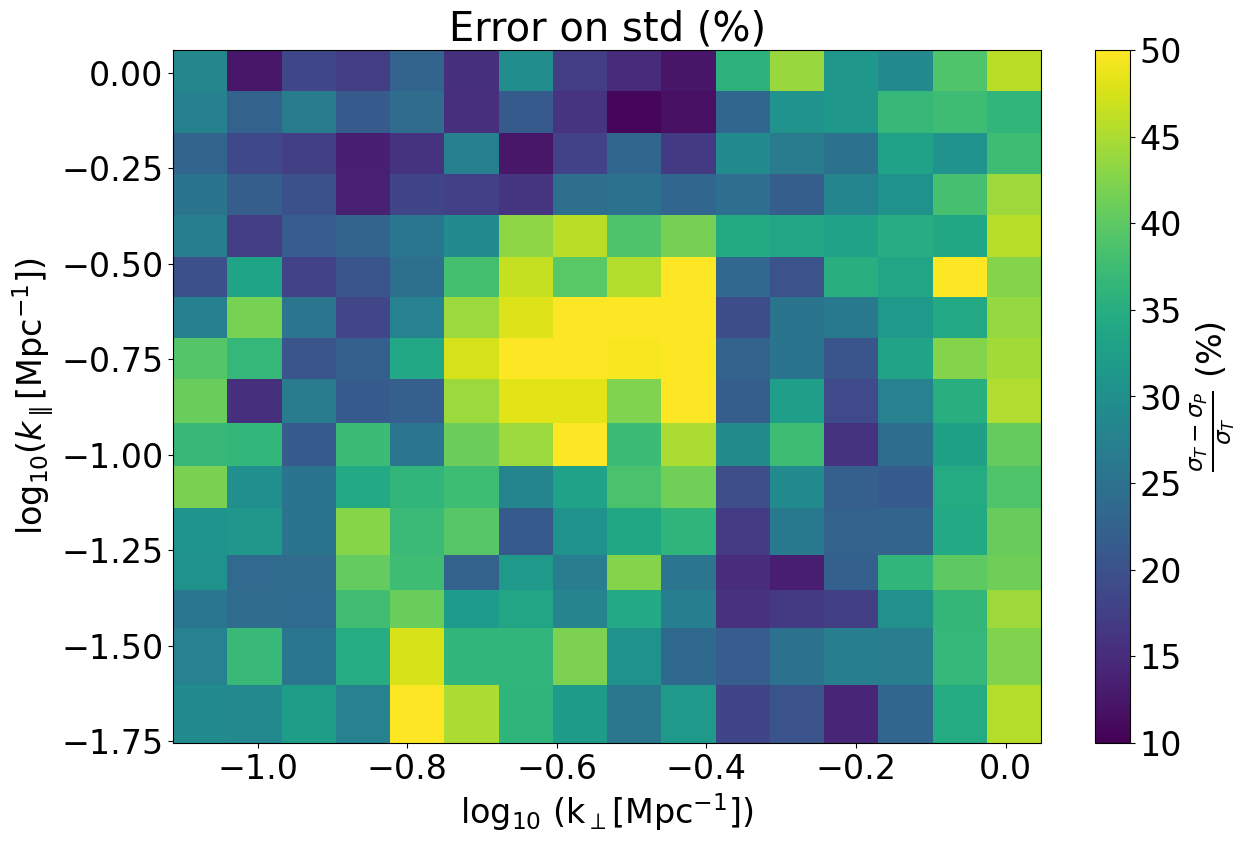

In [27]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 10, vmax = 50., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

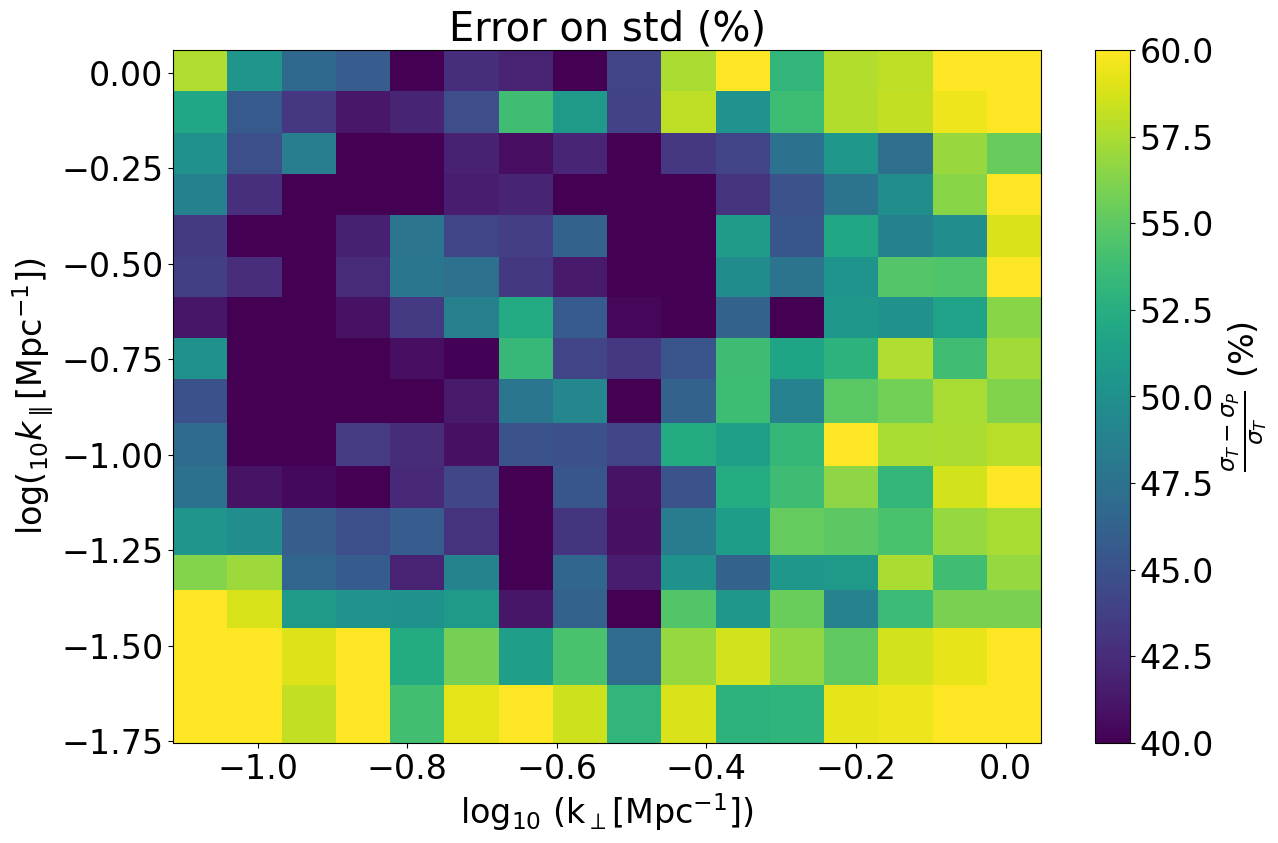

In [99]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 40, vmax = 60., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [29]:
ffee = abs((mean_pred - ps_data[...,1]) / ps_data[...,1])
med_fe = np.nanmedian(ffee, axis = 0)

In [30]:
med_fe.min()*100

14.929040681616396

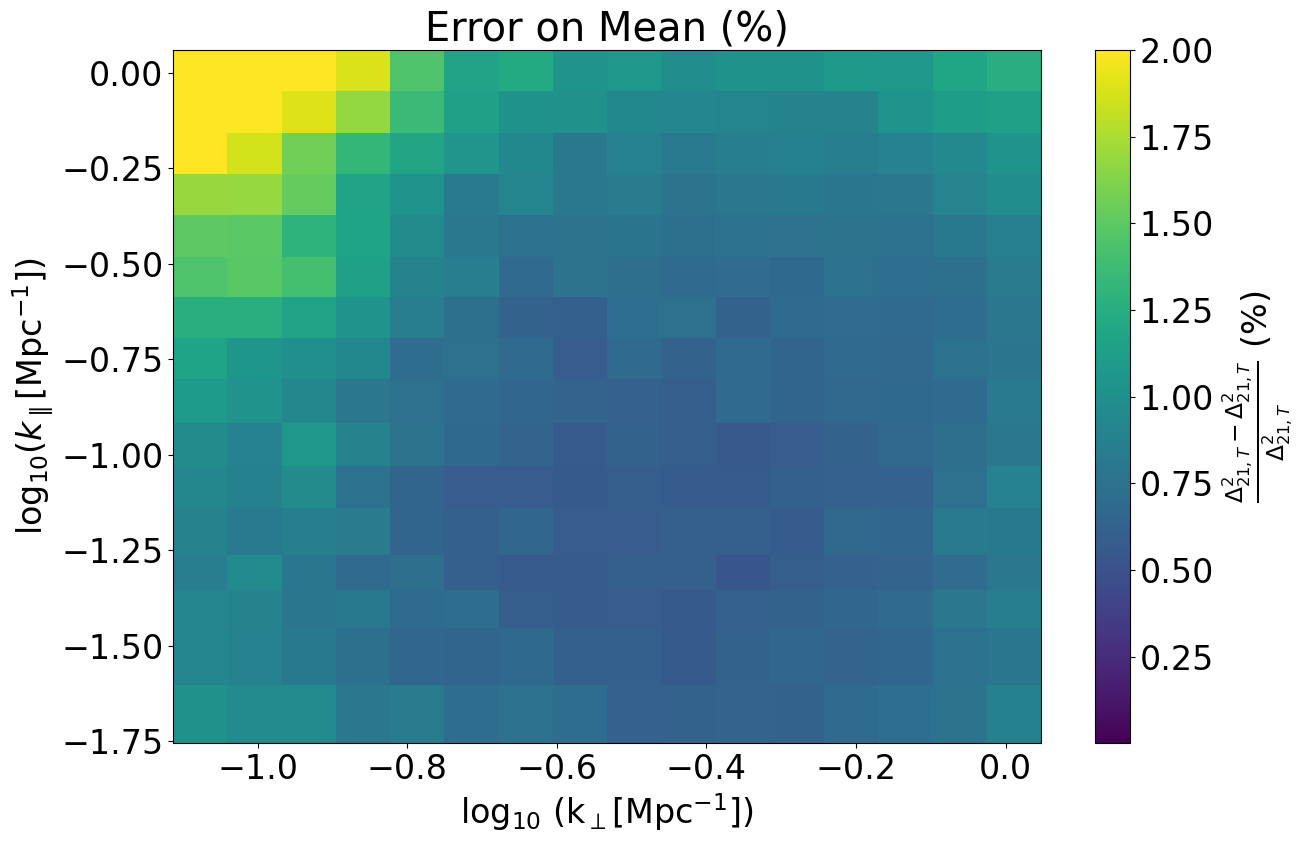

In [50]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 1e-3, vmax = 2., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

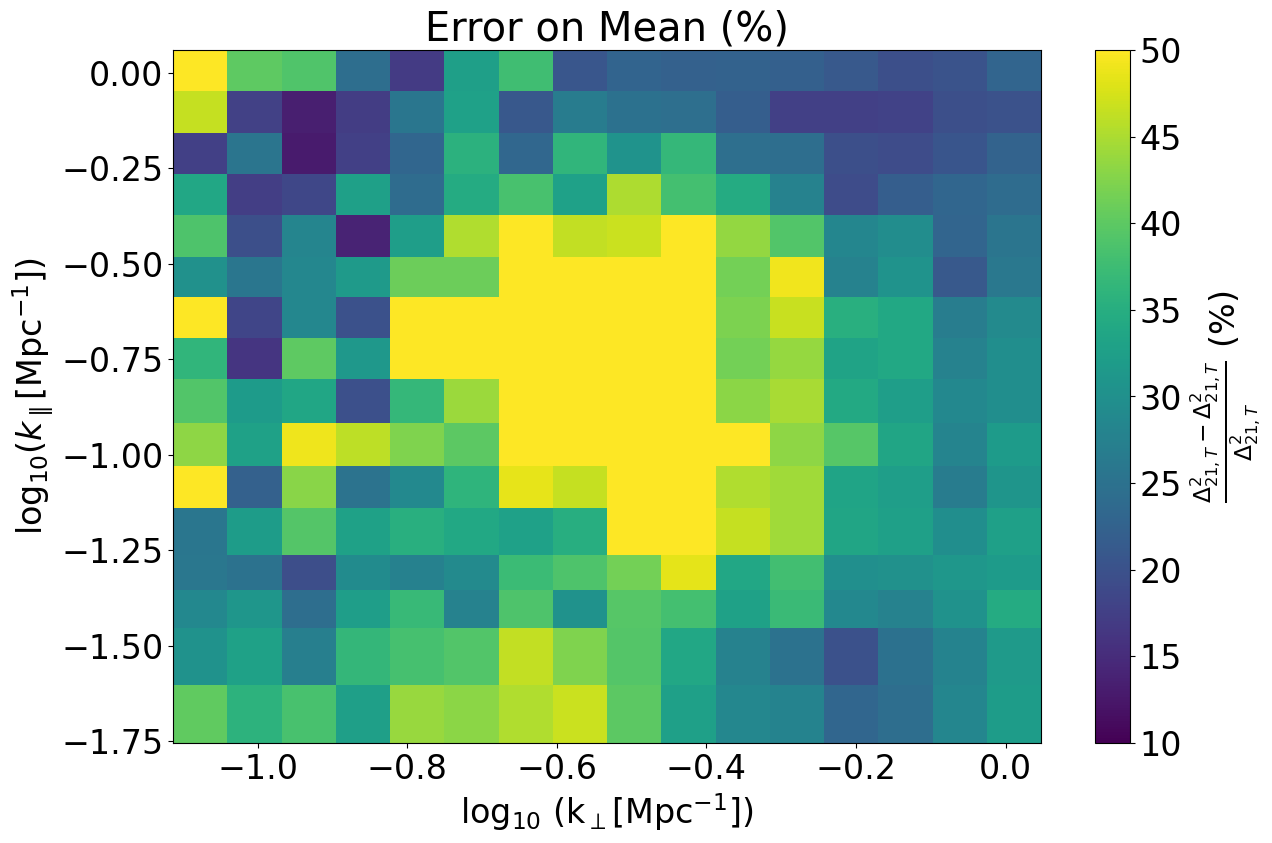

In [19]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 10., vmax = 50., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

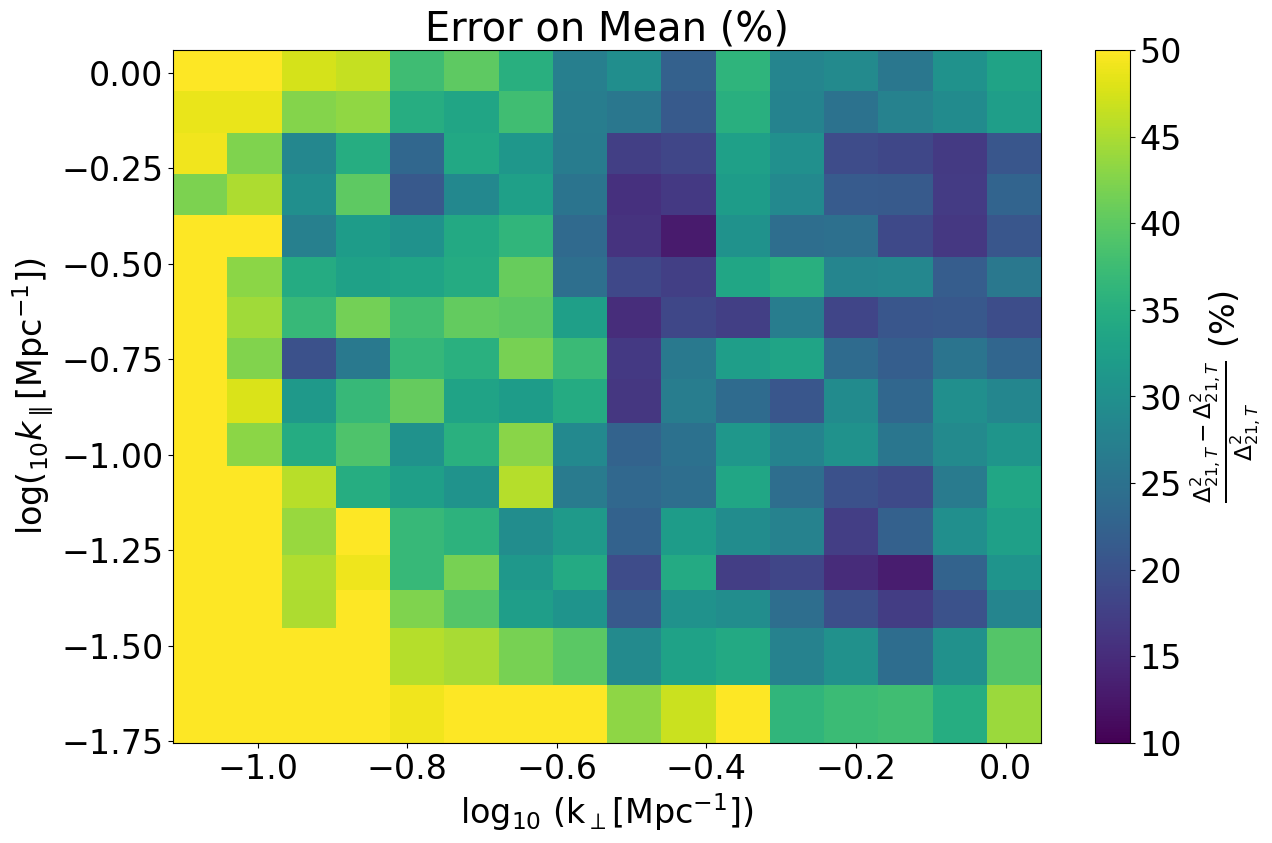

In [104]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 10., vmax = 50., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [56]:
N = 2371

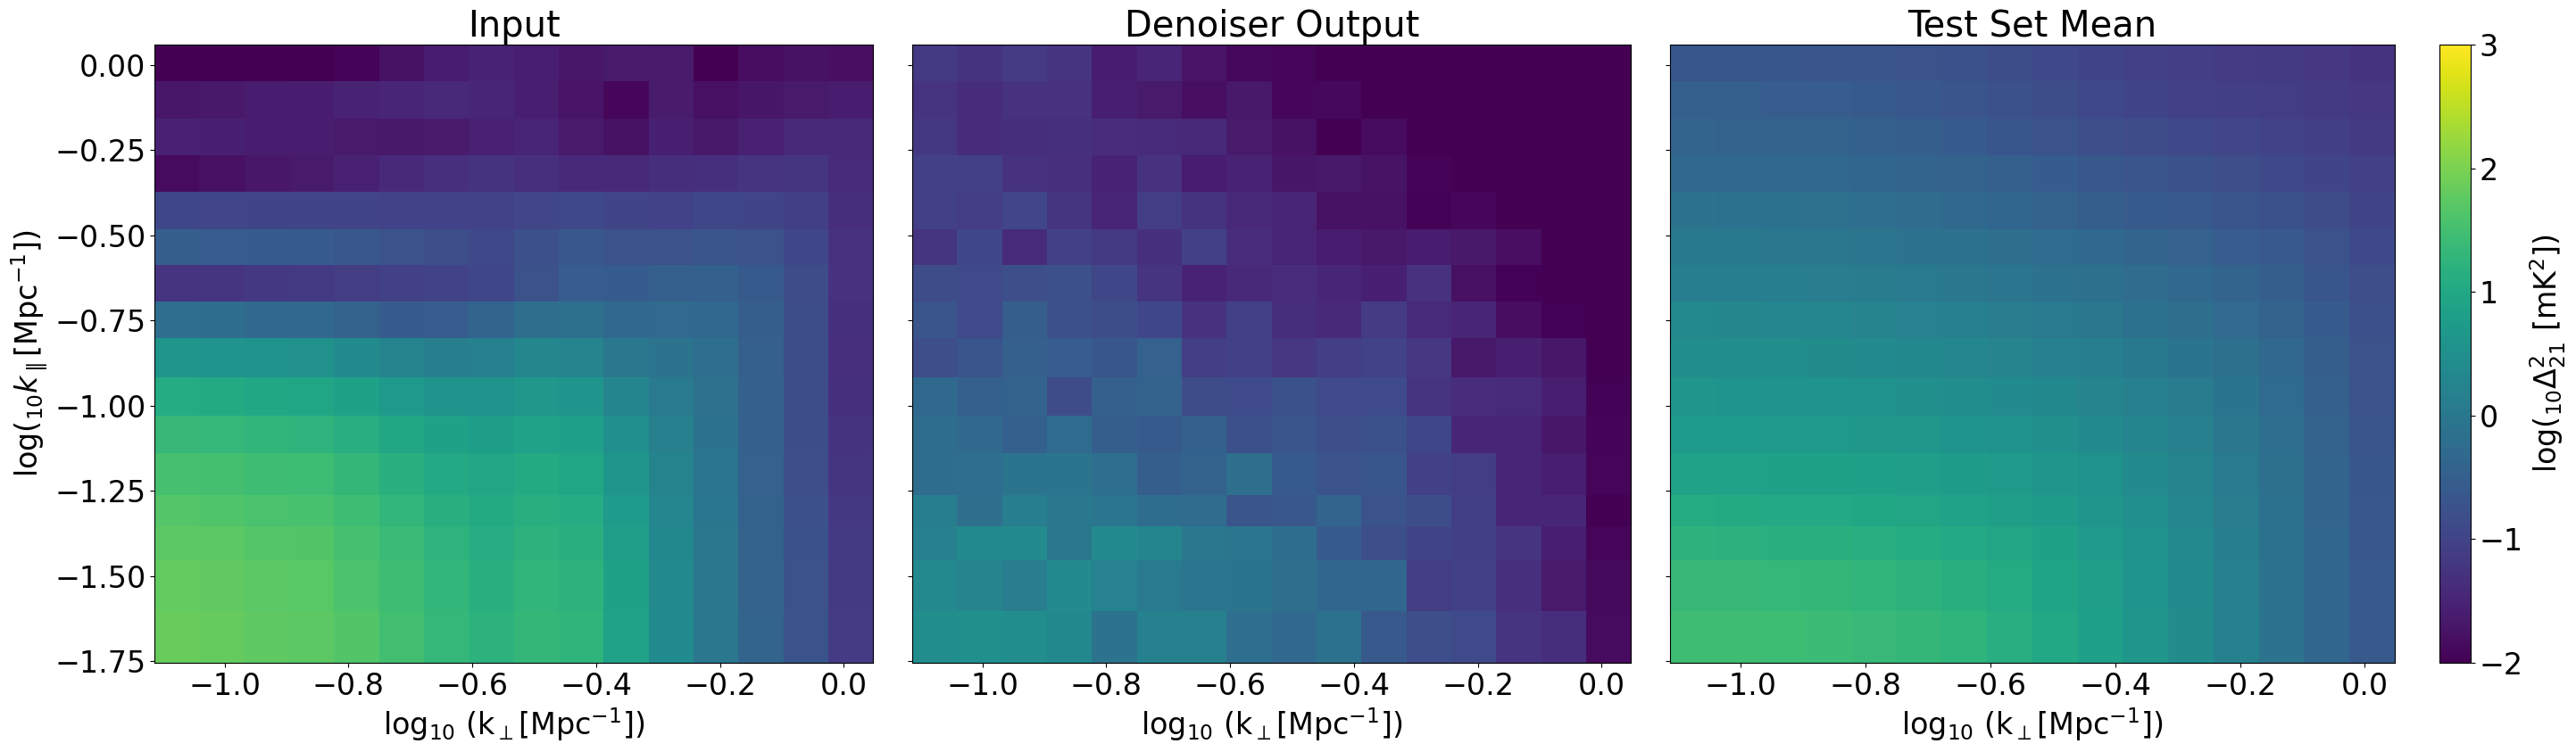

In [63]:
imshow_error_2D(mean_pred[N,...], truthmean = ps_data[N,...,1], 
             truthCV = ps_data[N,...,0], xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = -2, vmax = 3, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

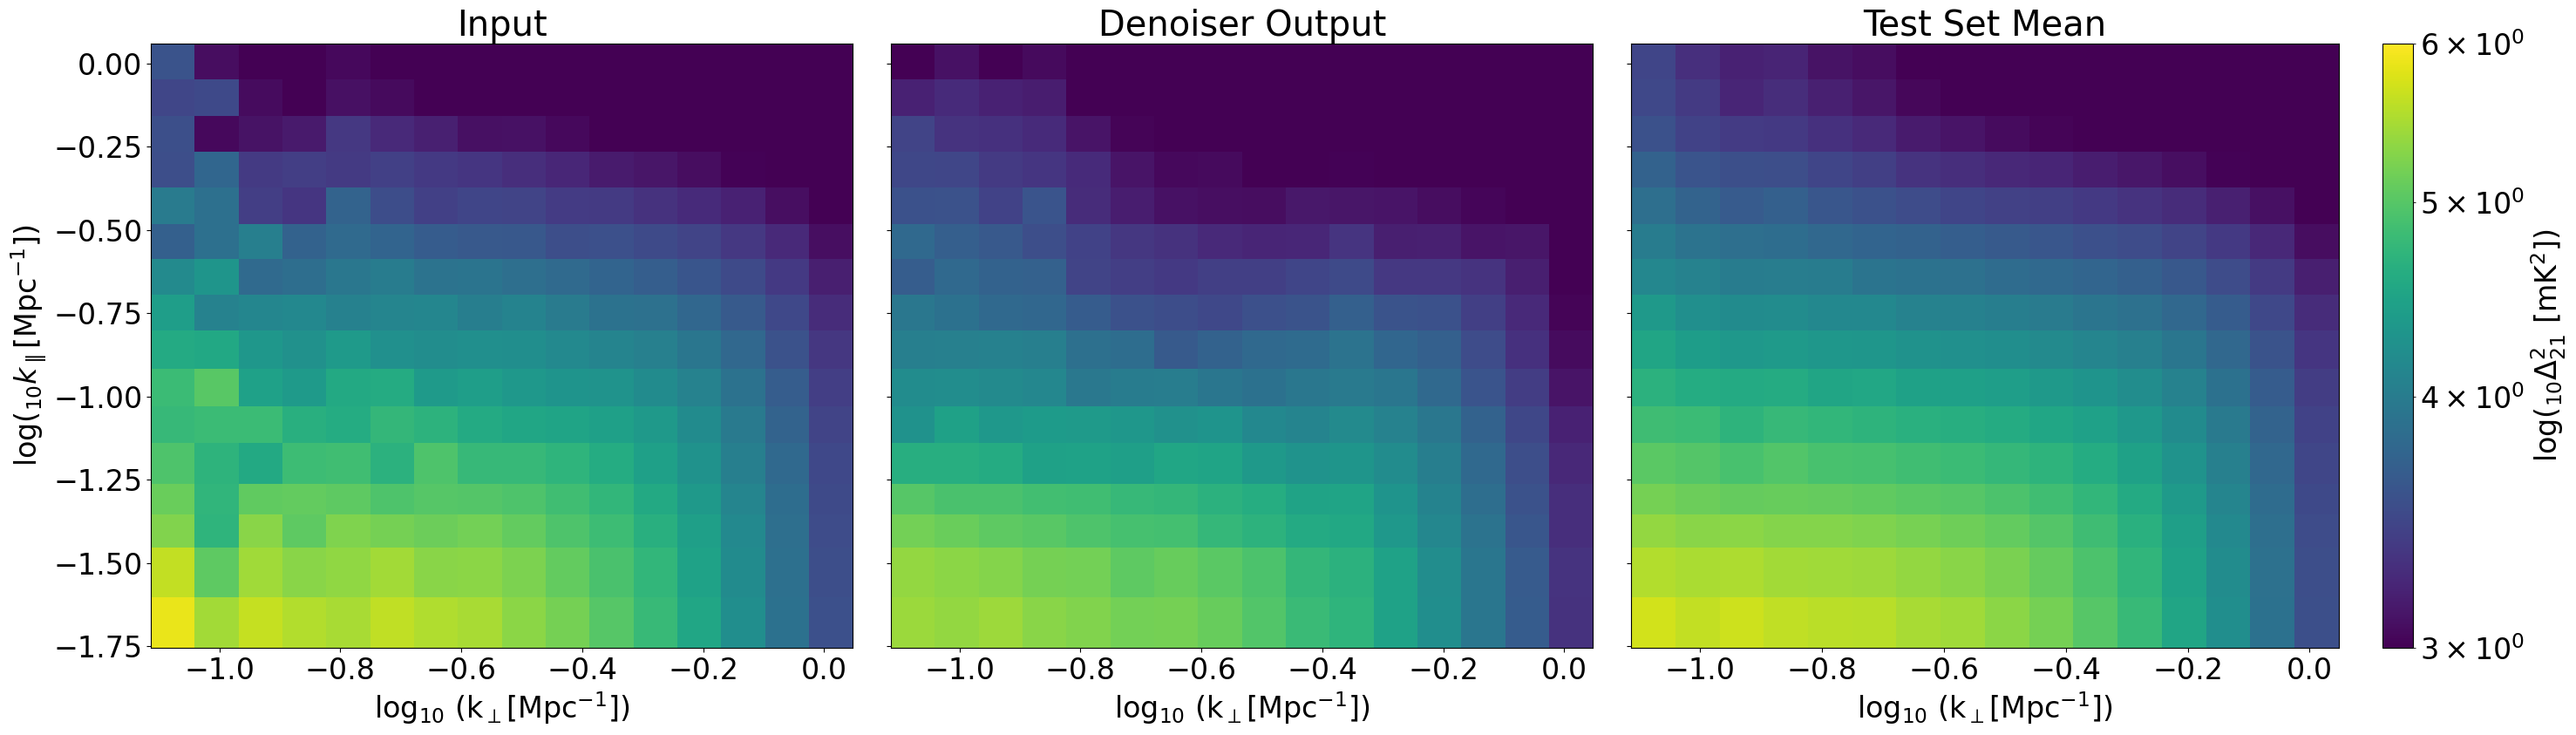

In [21]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 3, vmax = 6, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

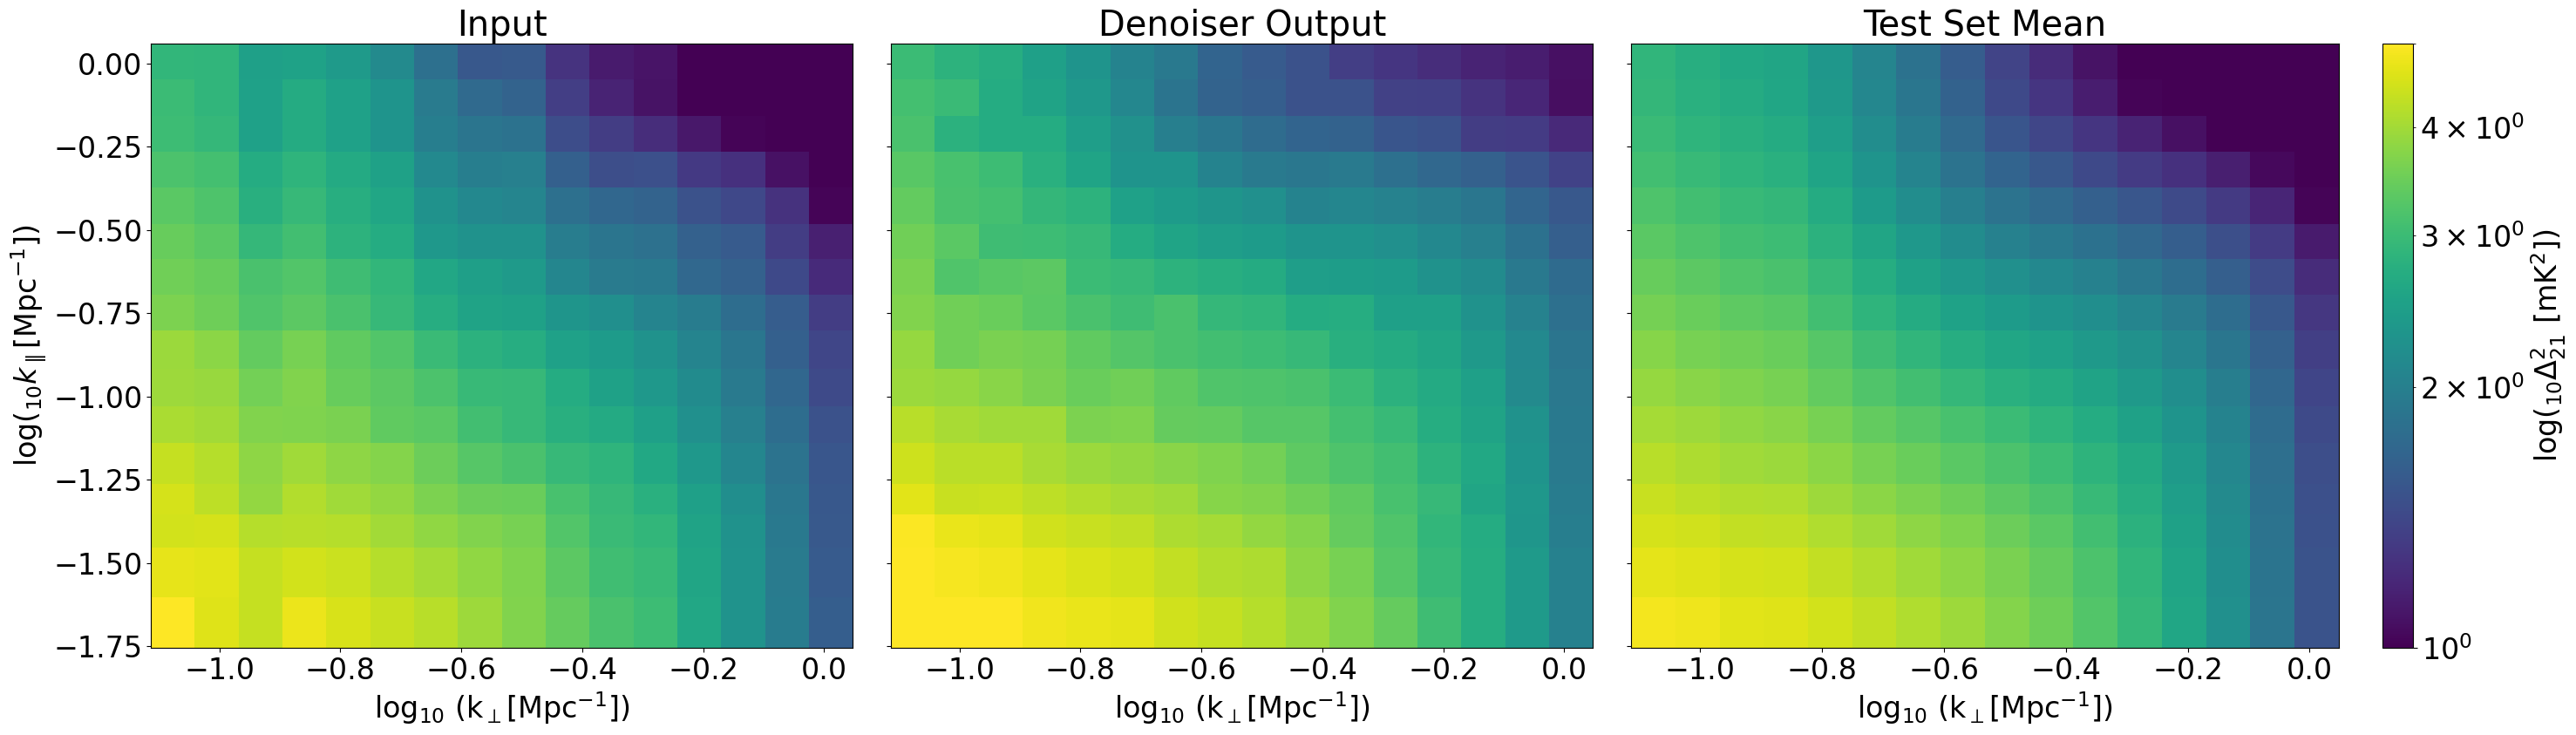

In [34]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 1, vmax = 5, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

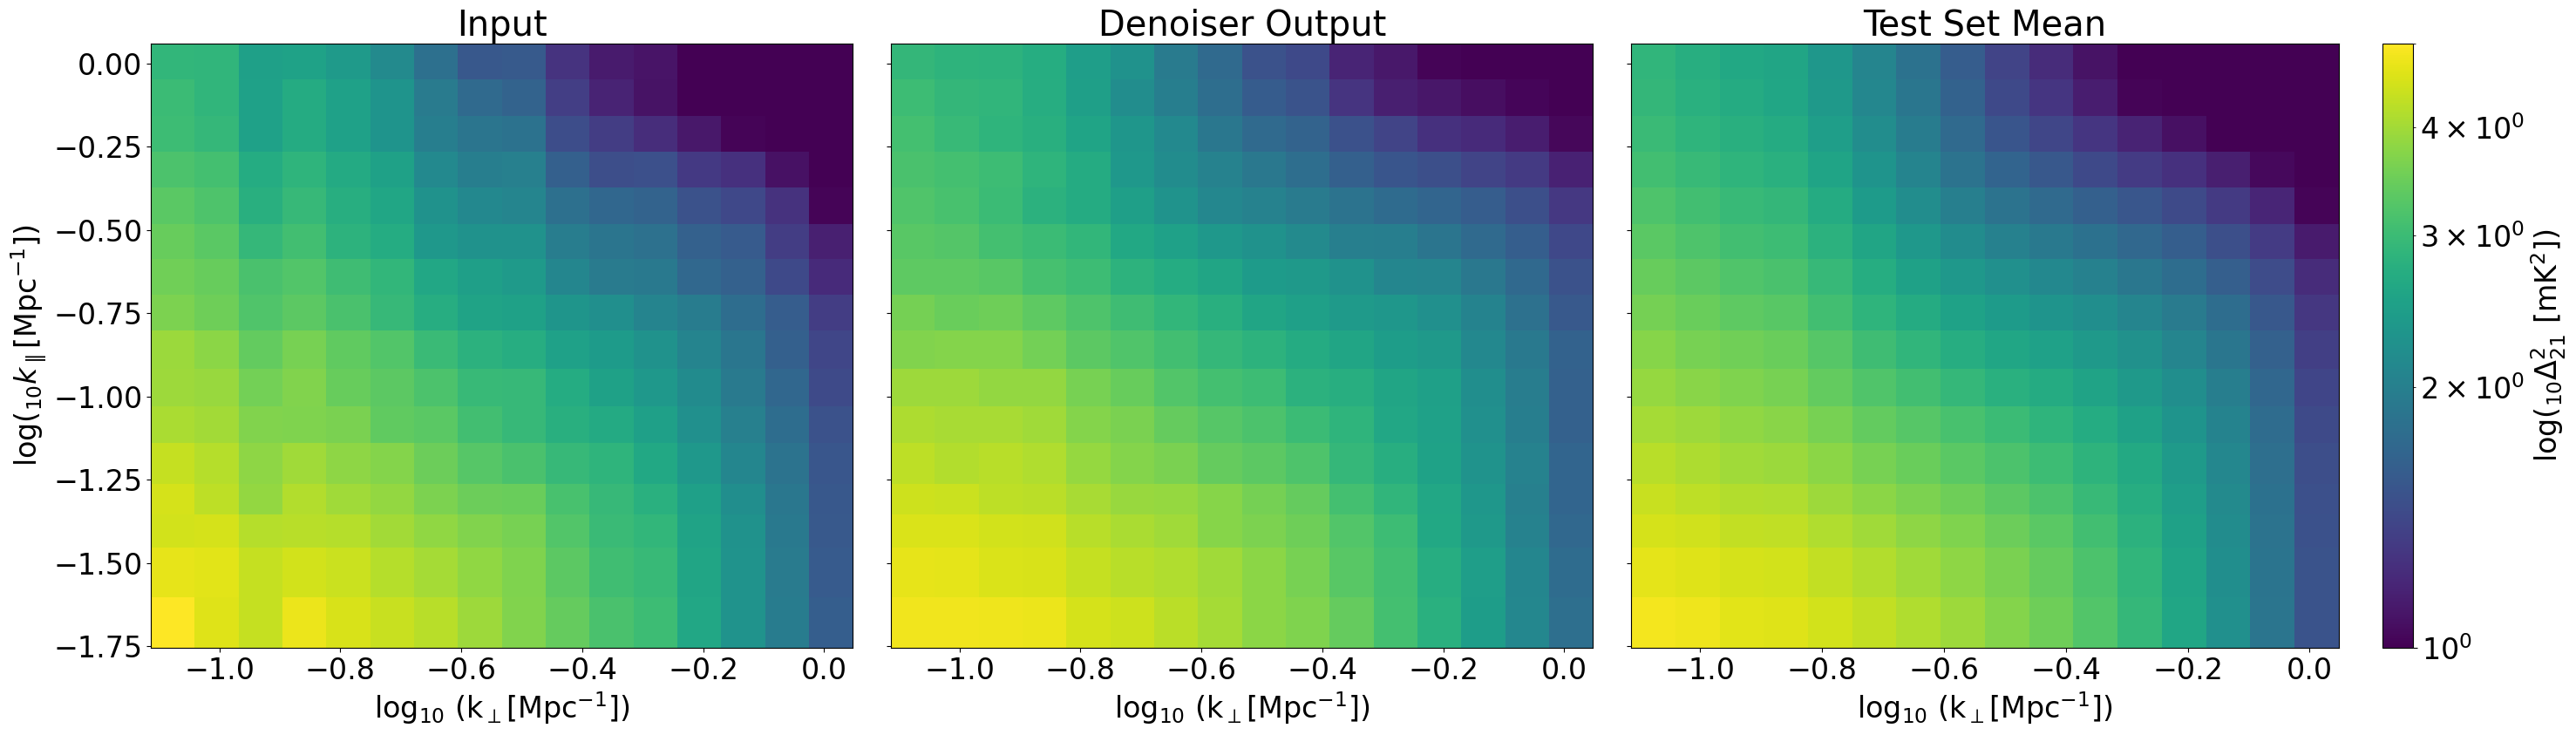

In [106]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 1, vmax = 5, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

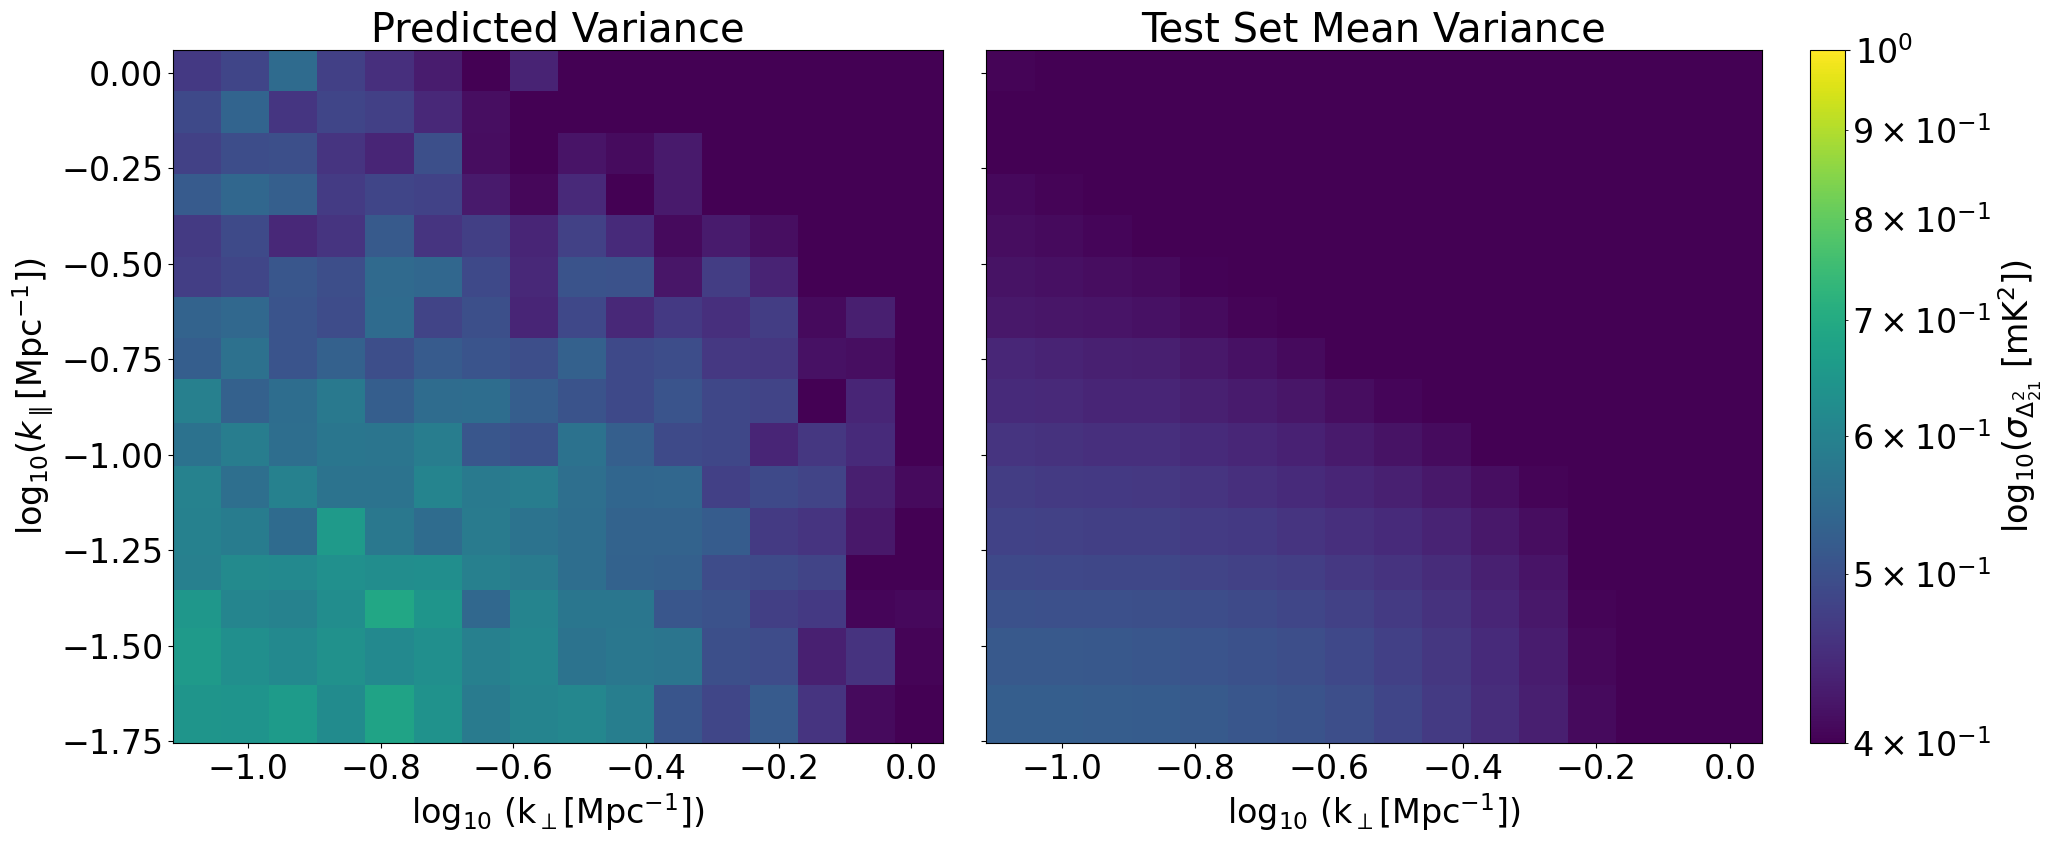

In [69]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 0.4, vmax = 1, label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

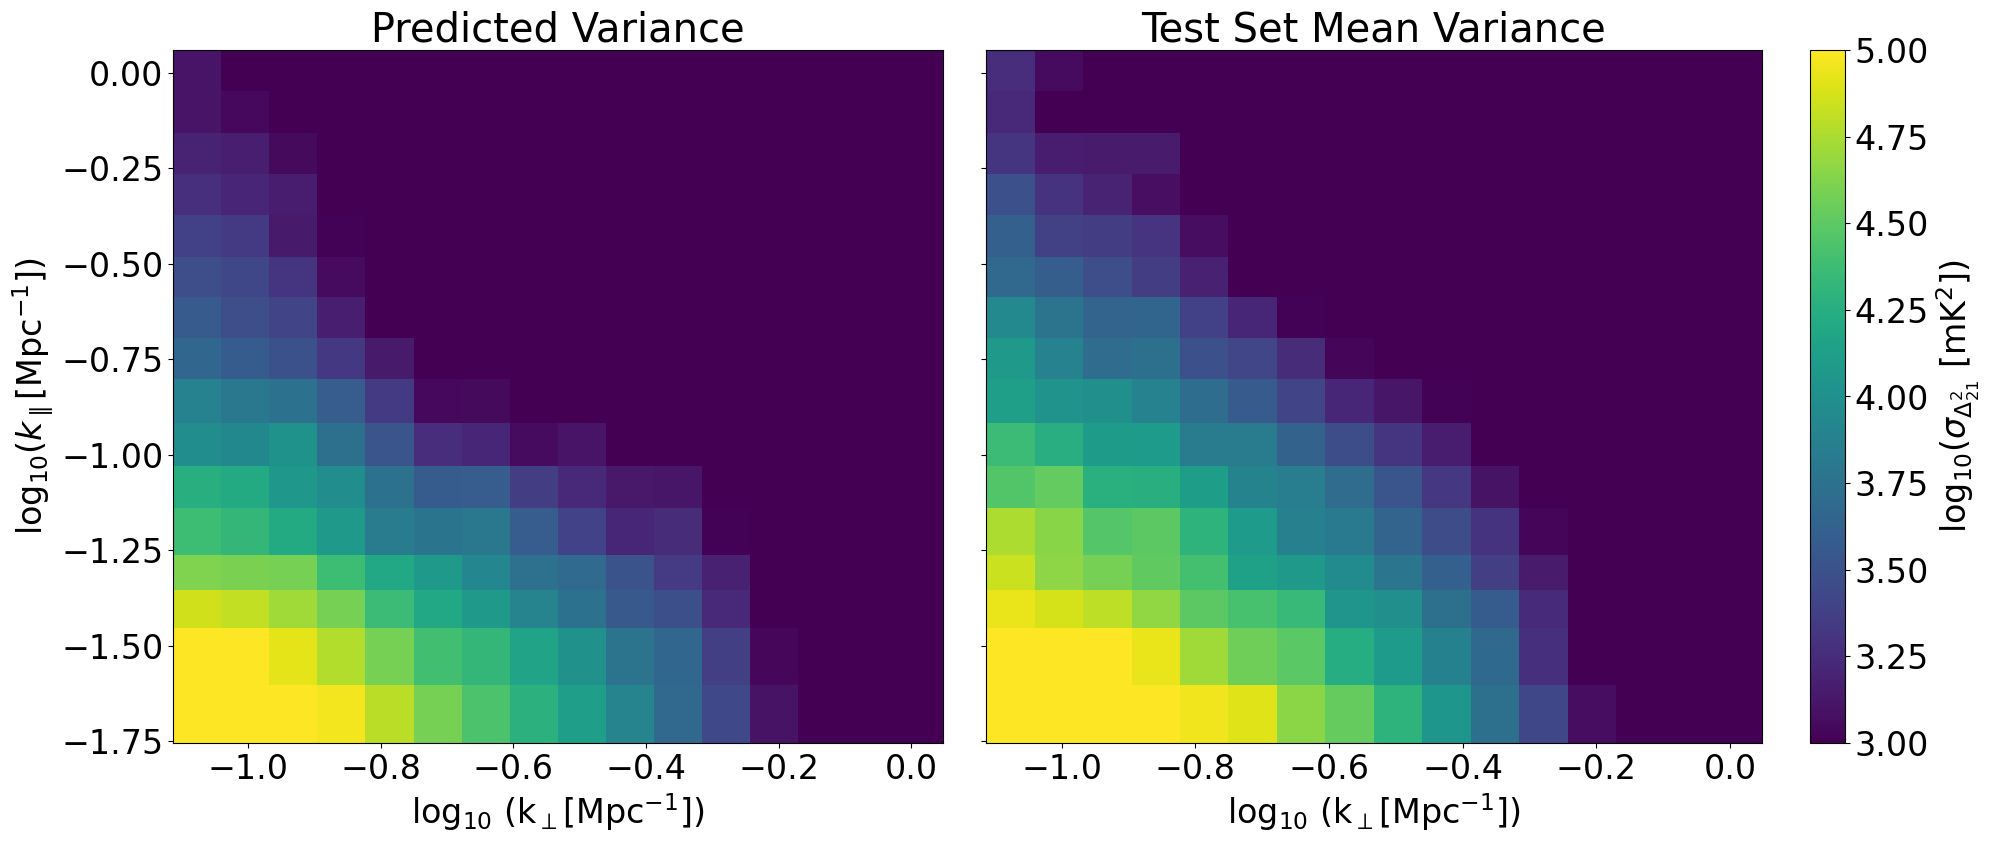

In [25]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 3, vmax = 5, label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

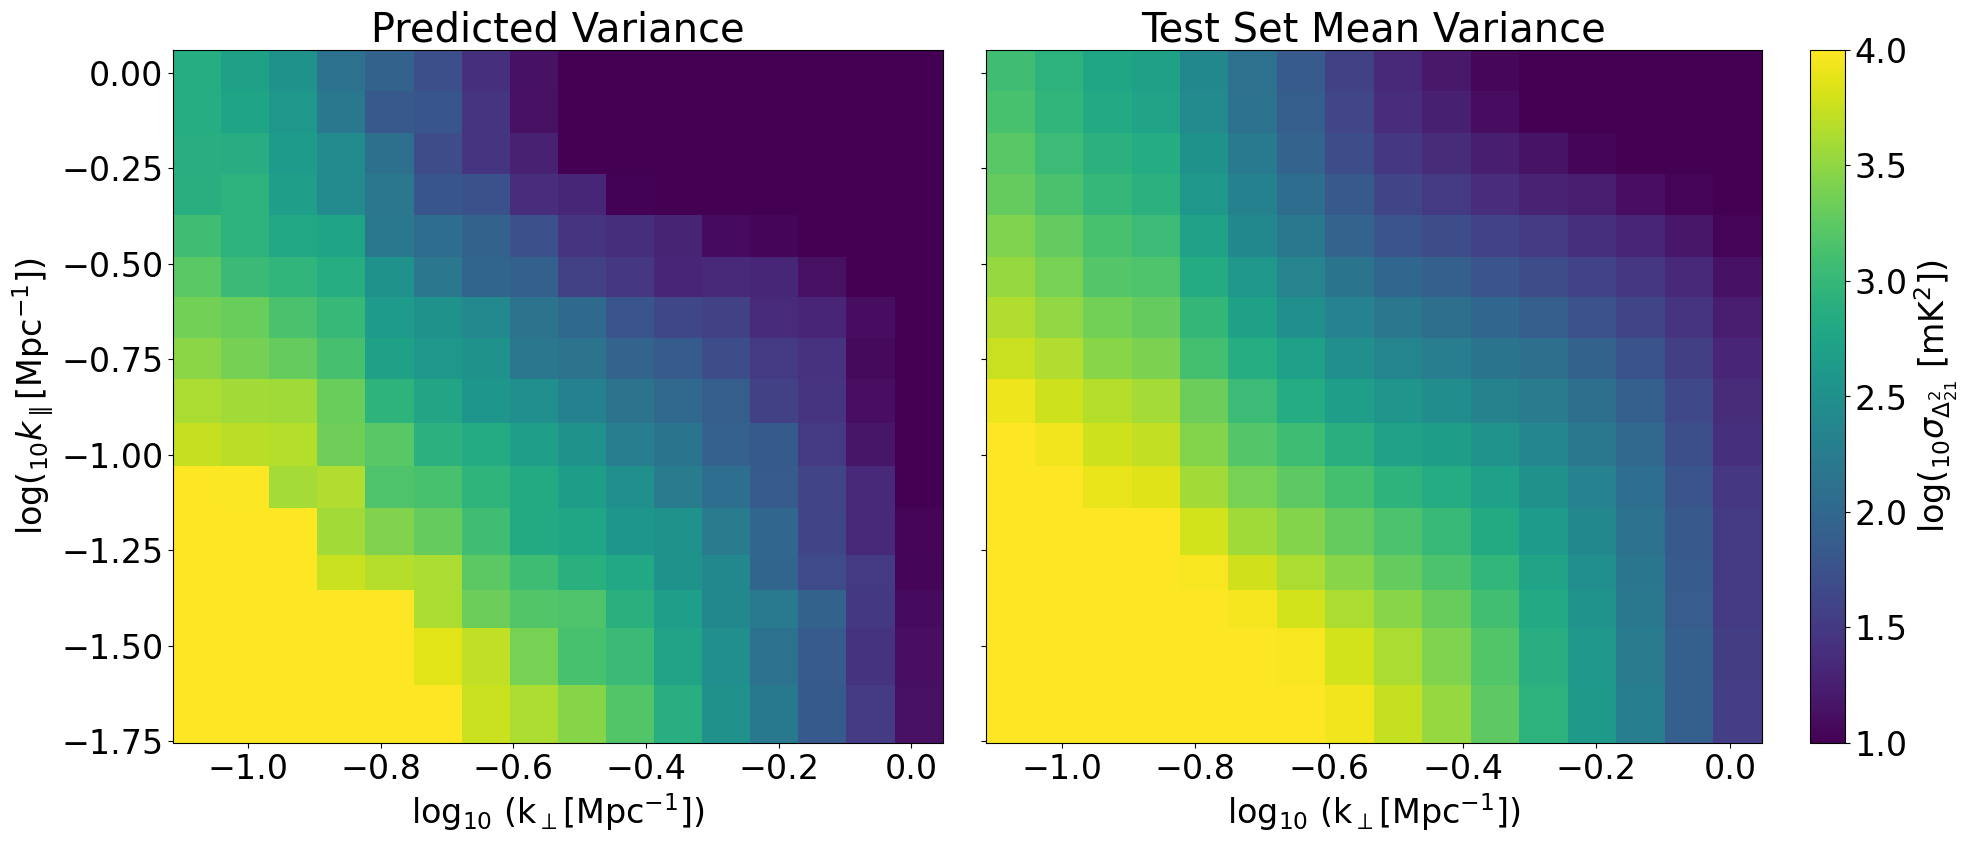

In [35]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 1, vmax = 4, label = r'log($_{10}\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

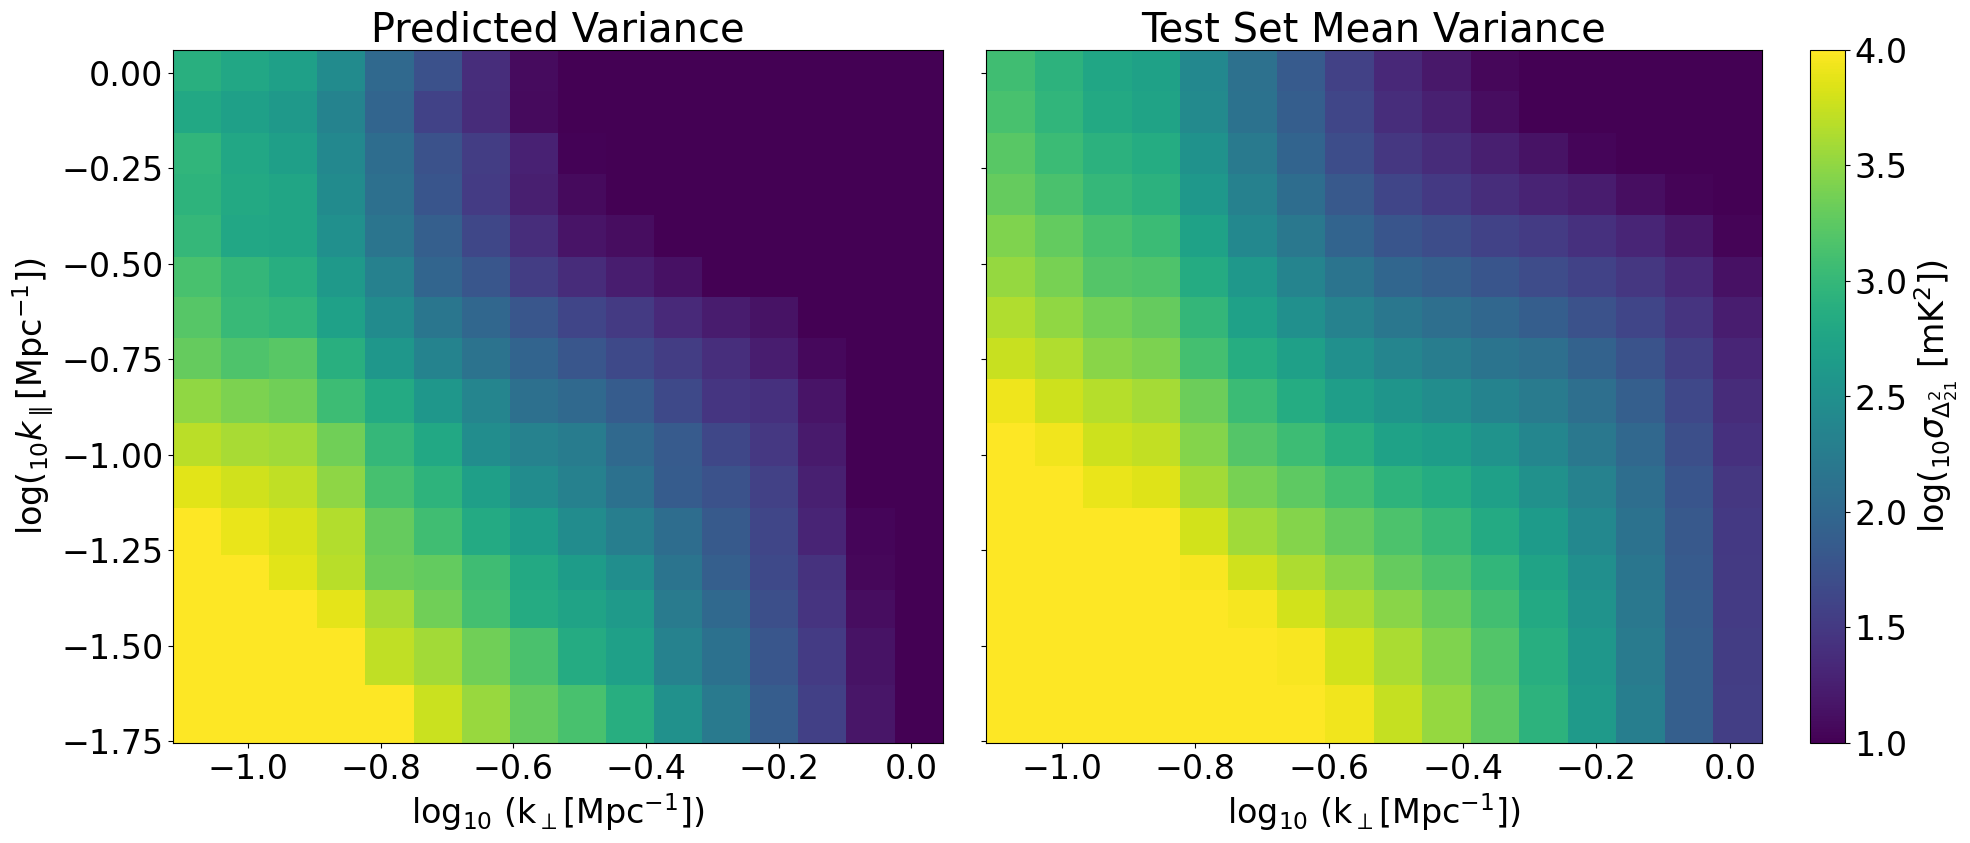

In [107]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 1, vmax = 4, label = r'log($_{10}\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [108]:
fe = abs((ps_data[...,1] - mean_pred)/ps_data[...,1]) * 100.
print('Compare id: ', np.median(fe))

Compare id:  33.25846180639999


/var/tmp/pbs.189392.pbs01/ipykernel_187584/2042992461.py:1: RuntimeWarning: divide by zero encountered in true_divide
  fe = abs((ps_data[...,1] - mean_pred)/ps_data[...,1]) * 100.


In [125]:
fe = abs((std_means - std_pred)/std_means) * 100.

print('Compare true std w pred std: %.3f' % np.nanmedian(fe))

fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmedian(fe2))


fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmedian(fe3))

if np.median(fe3) < np.median(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 49.309
Compare true mean w noisy PS: 11.741
Compare true mean w pred mean: 33.258
Then the network sucks and it's better to just use the noisy sample to estimate the mean.


/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:1: RuntimeWarning: divide by zero encountered in true_divide
  fe = abs((std_means - std_pred)/std_means) * 100.
/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:5: RuntimeWarning: invalid value encountered in true_divide
  fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:9: RuntimeWarning: divide by zero encountered in true_divide
  fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.


In [25]:
N = 0
z_idx = 3

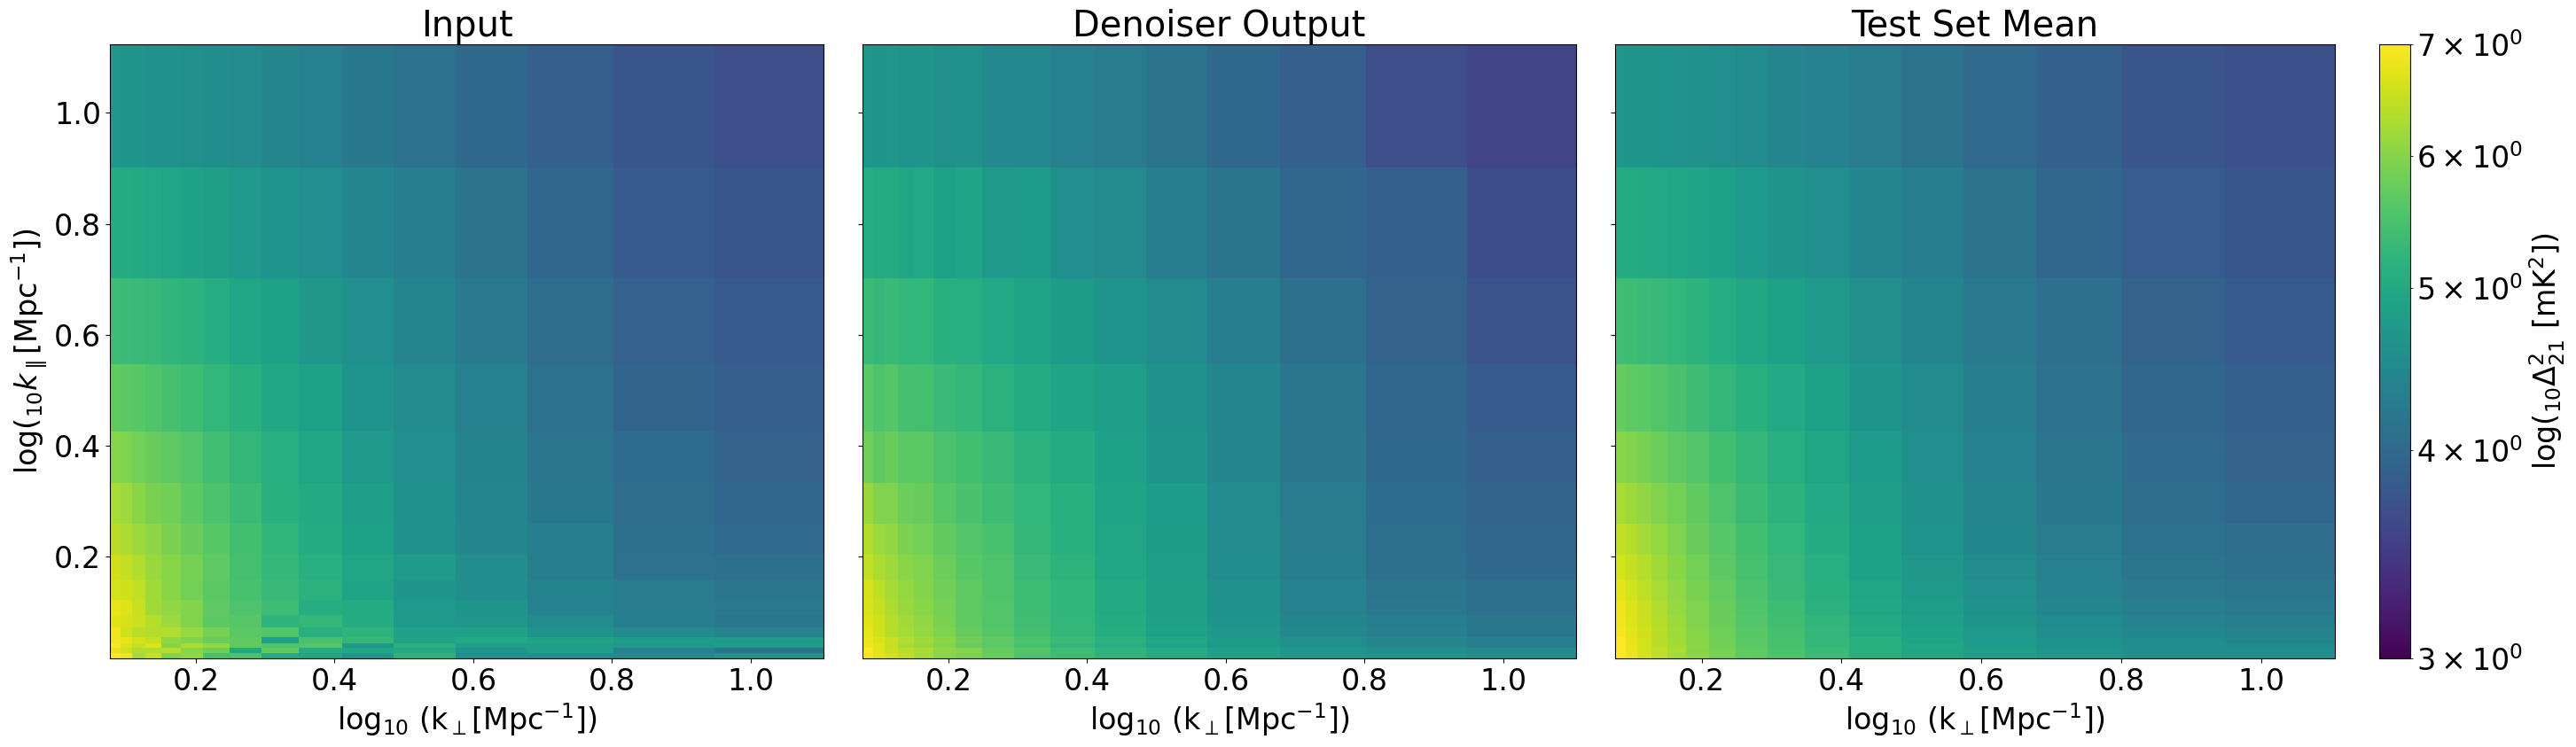

In [26]:
imshow_error_2D(np.log10(Y_pred[N,z_idx,...]), truthmean = np.log10(original_data[N,z_idx,...,1]), 
             truthCV = np.log10(original_data[N,z_idx,...,0]), xs_plot = kperp, ys_plot = kpar,
             vmin = 3, vmax = 7, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

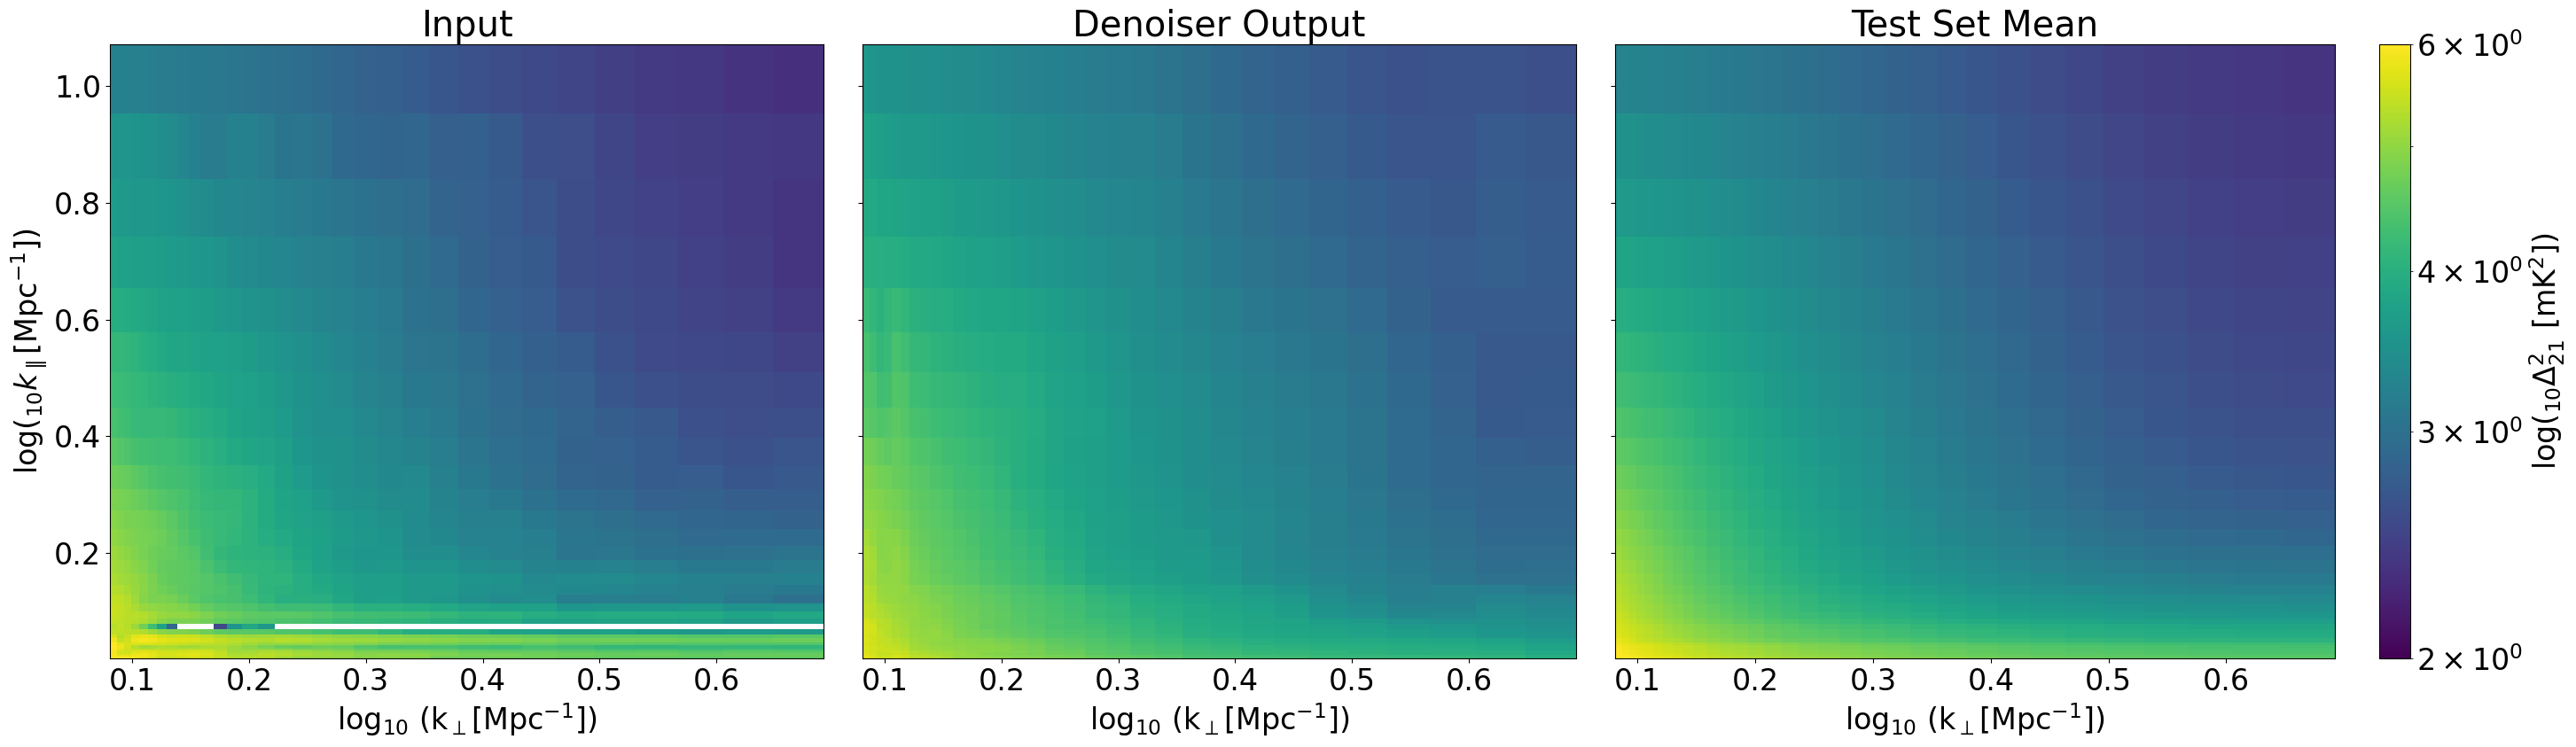

In [32]:
imshow_error_2D(Y_pred[N,z_idx,...], truthmean = original_data[N,z_idx,...,1], 
             truthCV = original_data[N,z_idx,...,0], xs_plot = kperp, ys_plot = kpar,
             vmin = 2, vmax = 6, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

In [53]:
fe_avg = np.nanmean(np.nanmean(fe, axis = 0), axis = 0)

In [54]:
fe_avg.max()

12.096278297459142

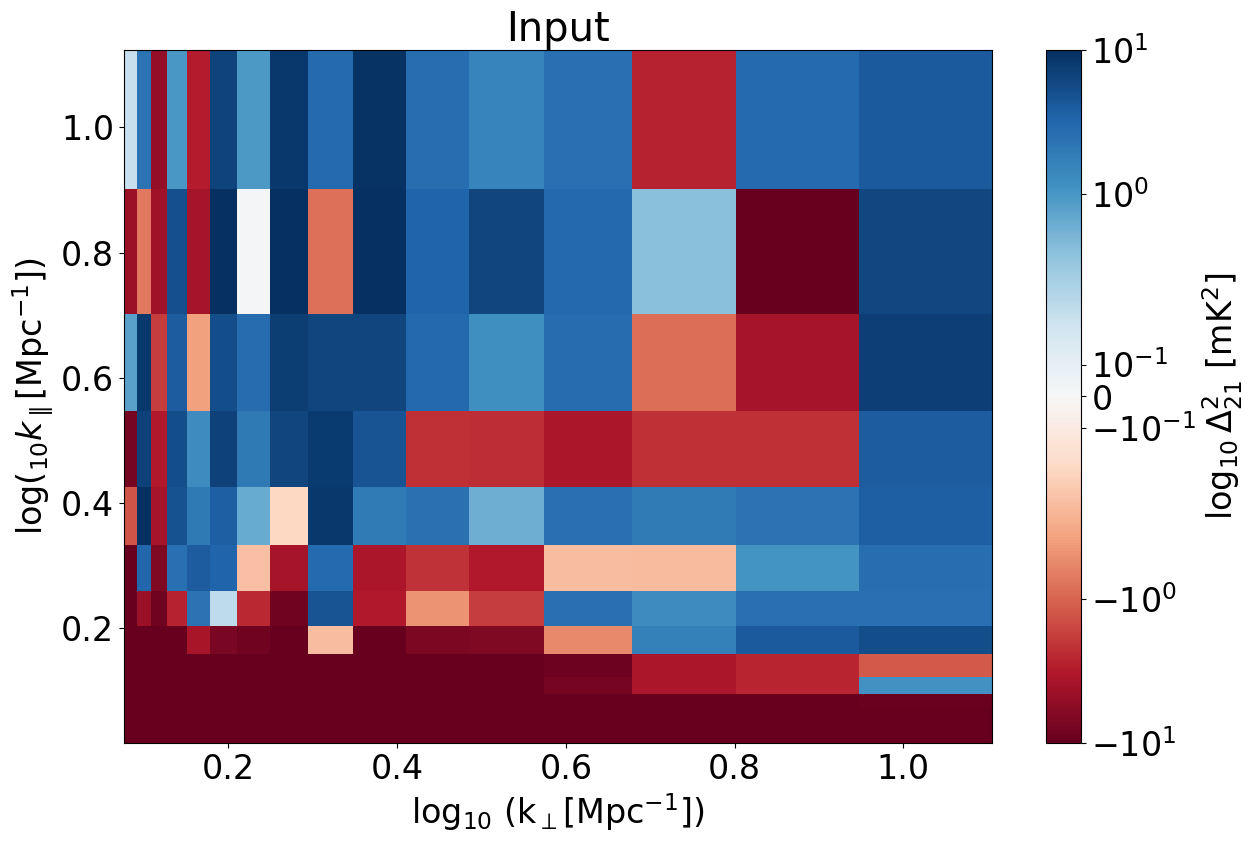

In [56]:
imshow_error_2D(fe_avg,xs_plot = kperp, ys_plot = kpar, vmin = -10, vmax = 10, cmap = 'RdBu')